In [3]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10
from matplotlib.ticker import FuncFormatter
import seaborn as sns



import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

In [4]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

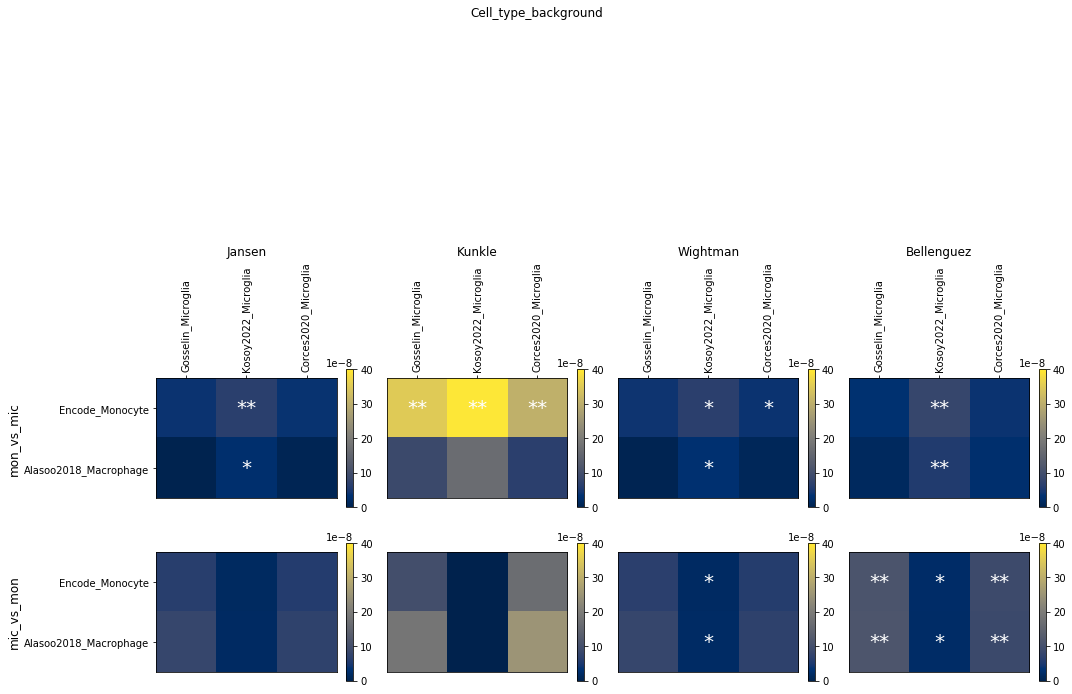

In [5]:
plt.close()

mon_ct_names = ["Encode_Monocyte",
                "Alasoo2018_Macrophage"
               ]
mic_ct_names = ["Gosselin_Microglia",
                "Kosoy2022_Microglia",
                "Corces2020_Microglia"
               ]

gwas_names = ['Jansen',
              'Kunkle',
              'Wightman',
              'Bellenguez'
             ]


forward_path = "/home/eramamur/ldsc_mic_vs_mon/mon_vs_mic"
reverse_path = "/home/eramamur/ldsc_mic_vs_mon/mic_vs_mon"


fig,axs = plt.subplots(2,4,figsize=(15,15))

for i,results_path in enumerate([forward_path,reverse_path]):
    for j,gwas_name in enumerate(gwas_names):
        filename = gwas_name+'.cell_type_results.txt'
        gwas_data = pd.read_csv(os.path.join(results_path,filename),sep='\t')
    

        data_coeff = pd.DataFrame(data=np.full((len(mon_ct_names),len(mic_ct_names)),
                                                np.nan),
                                   index=mon_ct_names,
                                   columns=mic_ct_names)

        data_pval = pd.DataFrame(data=np.full((len(mon_ct_names),len(mic_ct_names)),
                                                    np.nan),
                                       index=mon_ct_names,
                                       columns=mic_ct_names)
        if results_path==forward_path:
            gwas_data['CT1'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[0])
            gwas_data['CT2'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[1])
        elif results_path==reverse_path:
            gwas_data['CT1'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[1])
            gwas_data['CT2'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[0])                

        for _,row in gwas_data.iterrows():
            data_coeff.at[row['CT1'],row['CT2']] = row['Coefficient']
            data_pval.at[row['CT1'],row['CT2']] = row['Coefficient_P_value']

        im = axs[i,j].imshow(data_coeff, cmap=matplotlib.cm.cividis, vmin=0, vmax=40e-8)
        
        for k,ct1 in enumerate(data_coeff.index):
            for l, ct2 in enumerate(data_coeff.columns):
                if data_pval.loc[ct1][ct2] < 0.01/data_pval.size:
                    text='**'
                elif data_pval.loc[ct1][ct2] < 0.05/data_pval.size:
                    text='*'
                else:
                    text=''
                
                text = axs[i,j].text(l,
                               k,
                               text,
                               ha="center",
                               va="center",
                               color="w",
                               fontsize=20
                              )

        cb = plt.colorbar(im, ax=axs[i,j], fraction=0.035)
        cb.formatter.set_scientific(True)
        cb.formatter.set_powerlimits((-8,-8))
        cb.update_ticks()

        axs[i,j].set_yticks(range(data_coeff.shape[0]))
        axs[i,j].set_yticklabels(data_coeff.index, rotation=0)
        axs[i,j].set_xticks(range(data_coeff.shape[1]))
        axs[i,j].set_xticklabels(data_coeff.columns, rotation=90)
        axs[i,j].xaxis.tick_top()

        if i==0:
            axs[i,j].set_title(gwas_name)
            
        if j==0:
            if i==0:
                axs[i,j].set_ylabel("mon_vs_mic",fontsize=12)
            elif i==1:
                axs[i,j].set_ylabel("mic_vs_mon",fontsize=12)
        else:
            axs[i,j].set_yticks([])
        if i>0:
            axs[i,j].set_xticks([])




fig.suptitle('Cell_type_background')
plt.tight_layout()
plt.savefig("plots/ldsc_results_heatmap.svg")
plt.savefig("plots/ldsc_results_heatmap.png")

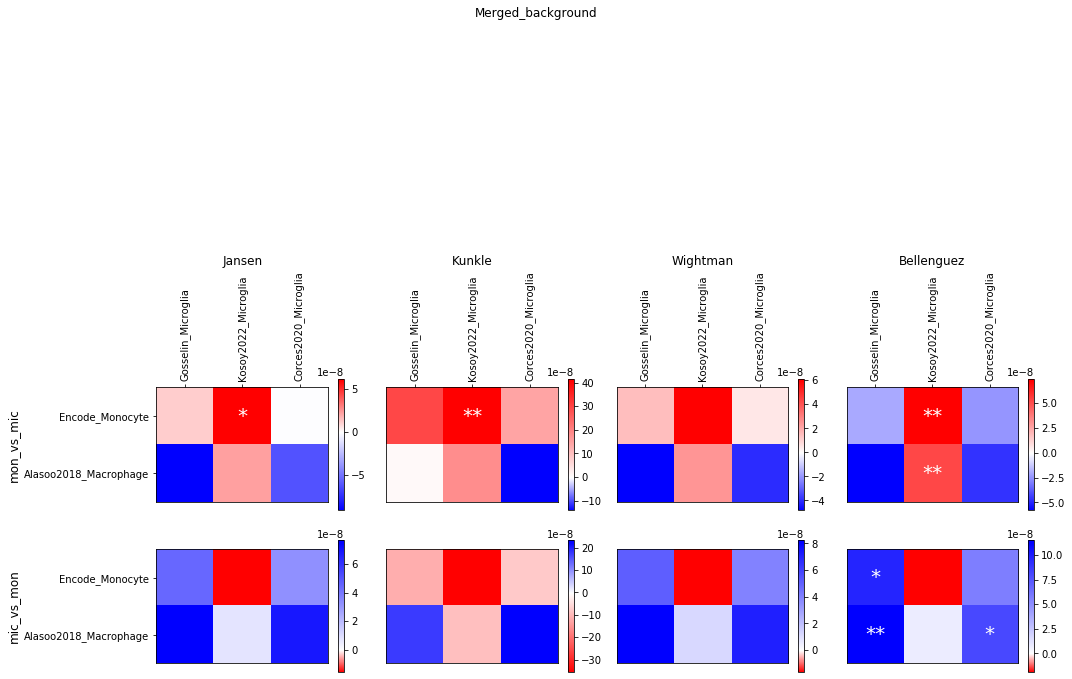

In [6]:
plt.close()


forward_path = "/home/eramamur/ldsc_mic_vs_mon/mon_vs_mic_merged"
reverse_path = "/home/eramamur/ldsc_mic_vs_mon/mic_vs_mon_merged"


fig,axs = plt.subplots(2,4,figsize=(15,15))

for i,results_path in enumerate([forward_path,reverse_path]):
    for j,gwas_name in enumerate(gwas_names):
        filename = gwas_name+'.cell_type_results.txt'
        gwas_data = pd.read_csv(os.path.join(results_path,filename),sep='\t')
    

        data_coeff = pd.DataFrame(data=np.full((len(mon_ct_names),len(mic_ct_names)),
                                                np.nan),
                                   index=mon_ct_names,
                                   columns=mic_ct_names)

        data_pval = pd.DataFrame(data=np.full((len(mon_ct_names),len(mic_ct_names)),
                                                    np.nan),
                                       index=mon_ct_names,
                                       columns=mic_ct_names)
        if results_path==forward_path:
            gwas_data['CT1'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[0])
            gwas_data['CT2'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[1])
        elif results_path==reverse_path:
            gwas_data['CT1'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[1])
            gwas_data['CT2'] = gwas_data['Name'].apply(lambda x: x.split("_vs_")[0])                

        for _,row in gwas_data.iterrows():
            data_coeff.at[row['CT1'],row['CT2']] = row['Coefficient']
            data_pval.at[row['CT1'],row['CT2']] = row['Coefficient_P_value']

        vmax = np.amax(data_coeff.values)
        vmin = np.amin(data_coeff.values)
        
        vmid = 1 - vmax / (vmax + abs(vmin))

        cmap_orig = matplotlib.cm.bwr

        if i==1:
            cmap_orig = matplotlib.cm.bwr_r
        
        new_cmap = shiftedColorMap(cmap_orig, midpoint=vmid)

        im = axs[i,j].imshow(data_coeff, cmap=new_cmap)
        
        for k,ct1 in enumerate(data_coeff.index):
            for l, ct2 in enumerate(data_coeff.columns):
                if data_pval.loc[ct1][ct2] < 0.01/data_pval.size:
                    text='**'
                elif data_pval.loc[ct1][ct2] < 0.05/data_pval.size:
                    text='*'
                else:
                    text=''
                
                text = axs[i,j].text(l,
                               k,
                               text,
                               ha="center",
                               va="center",
                               color="w",
                               fontsize=20
                              )

        cb = plt.colorbar(im, ax=axs[i,j], fraction=0.035)
        cb.formatter.set_scientific(True)
        cb.formatter.set_powerlimits((-8,-8))
        cb.update_ticks()

        axs[i,j].set_yticks(range(data_coeff.shape[0]))
        axs[i,j].set_yticklabels(data_coeff.index, rotation=0)
        axs[i,j].set_xticks(range(data_coeff.shape[1]))
        axs[i,j].set_xticklabels(data_coeff.columns, rotation=90)
        axs[i,j].xaxis.tick_top()

        if i==0:
            axs[i,j].set_title(gwas_name)
            
        if j==0:
            if i==0:
                axs[i,j].set_ylabel("mon_vs_mic", fontsize=12)
            elif i==1:
                axs[i,j].set_ylabel("mic_vs_mon", fontsize=12)
        else:
            axs[i,j].set_yticks([])
        if i>0:
            axs[i,j].set_xticks([])




fig.suptitle('Merged_background')
plt.tight_layout()
plt.savefig("plots/ldsc_results_heatmap_merged.svg")
plt.savefig("plots/ldsc_results_heatmap_merged.png")